# Test the ability of deepwalk to make predictions on semmeddb

Fold 0 only.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

from glob import glob
import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
%matplotlib inline

In [3]:
np.random.seed(20171115)

---

## Read semmeddb embedding

deepwalk parameters: 50 walks, 128 vecsize, 10 window size.

In [4]:
vecsize = 128

features = (pd
    .read_csv(
        "data/embeddings/sem50walk128vec10window.txt",
        sep=' ', skiprows=1,
        names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
    )
)

In [5]:
features.head()

,uid,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127
0,11728,-0.364880,3.792458,-1.397374,0.759112,2.917878,-0.176155,-0.564531,0.842563,-0.224761,...,-4.287377,2.291287,1.062728,-1.022062,1.158340,1.375489,0.707240,-0.798140,0.265549,1.008619
1,2049,-2.405818,-3.281208,5.442310,1.949694,2.385109,-0.819011,-0.049137,-0.012040,-2.015012,...,-5.956447,2.372664,-1.301351,-0.197150,-0.536069,-3.845875,1.893585,2.490709,-3.045699,-2.791694
2,8081,0.658723,0.207870,5.323104,-1.736953,5.051743,-1.999842,-3.380626,0.289445,2.042453,...,0.520123,-0.190908,0.161119,0.818972,-1.207367,0.406293,-0.056115,1.821121,1.328484,-4.362211
3,4369,-1.625476,7.181020,-3.710097,-3.370679,2.942568,-2.319238,2.756862,-0.547414,2.251278,...,-1.954914,2.358400,2.579734,-1.074741,0.438799,0.064437,0.036294,-1.126031,2.002540,0.159338
4,43199,0.880009,4.827002,2.897967,0.444787,-2.483543,1.696095,-6.284511,1.747533,1.588262,...,-3.107903,-0.838388,2.420102,-2.941679,5.887329,0.134784,1.972876,-1.104905,2.946468,2.954355


## Read training data

In [6]:
traind = pd.read_csv("data/training/clean_train0.tsv", sep='\t')

In [7]:
traind.head()

,chemical_id,disease_id,etype,chemical_uid,disease_uid
0,C0000473,C0000810,0,58,123
1,C0000477,C0000810,0,59,123
2,C0000618,C0000810,0,80,123
3,C0000948,C0000810,0,164,123
4,C0000956,C0000810,0,167,123


In [8]:
traind.shape

(1094871, 5)

## Subsample training data

In [9]:
trainpos = traind.query("etype == 1")
K = 3

train = (trainpos
    .append(
        (traind
            .query("etype == 0")
            .sample(len(trainpos) * K)
        )
    )
    .reset_index(drop=True)
)

## Add features

In [10]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [11]:
tmp = convolv_features(train, features, vecsize)

## Train classifier

In [12]:
feat_cols = ["conv{}".format(i) for i in range(vecsize)]

model = LogisticRegression(C=1e9)
model.fit(tmp[feat_cols], tmp["etype"])

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Predict on holdout data

In [13]:
holdoutd = pd.read_csv("data/holdout/clean_holdout0.tsv", sep='\t')

In [14]:
test = convolv_features(holdoutd.drop("etype", axis=1), features, vecsize)

featcols = ["conv{}".format(i) for i in range(vecsize)]
ans = test.assign(predval = lambda df: model.predict_proba(df[featcols])[:, 1])

results = (ans
    [["chemical_id", "disease_id", "predval"]]
    .merge(
        holdoutd[["chemical_id", "disease_id", "etype"]],
        how="inner", on=["chemical_id", "disease_id"]
    )
)

In [15]:
results = results.rename(columns={"etype": "category"})

In [16]:
results.head()

,chemical_id,disease_id,predval,category
0,C0000473,C0001144,0.280261,0
1,C0000545,C0001144,0.460353,0
2,C0000618,C0001144,0.158595,0
3,C0000956,C0001144,0.013283,0
4,C0000970,C0001144,0.065635,0


## Draw curves

In [17]:
def plot_roc(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]].sort_values(metric)
        fpr, tpr, thresh = roc_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['fpr'] = fpr
        auroc_results[metric]['tpr'] = tpr
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(fpr, tpr)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
    plt.plot(x,x, 'k--', lw=2)
    for metric in metrics:
        plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('FPR', size=20)
    plt.ylabel('TPR', size=20)
    plt.title(title, size=24)
    plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16});

In [18]:
def plot_pr(res_df, metrics, name_map, title="ROC"):
    auroc_results = defaultdict(dict)

    for metric in metrics:
        tmp = res_df[["category", metric]]
        precision, recall, thresh = precision_recall_curve(tmp["category"], tmp[metric])

        auroc_results[metric]['precision'] = precision
        auroc_results[metric]['recall'] = recall
        auroc_results[metric]['thresh'] = thresh
        auroc_results[metric]['auc'] = auc(recall, precision)

    lw = 3
    x = [i for i in np.arange(0.0,1.01,.01)]
    for metric in metrics:
        plt.plot(auroc_results[metric]['recall'], auroc_results[metric]['precision'], lw=lw,
                 label='{0} (area = {1:0.2f})'
                     .format(name_map[metric], auroc_results[metric]['auc']))
    fig = plt.gcf()
    fig.set_size_inches(8, 7)
    fig.set_tight_layout(False)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title(title, size=24)
    plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16});

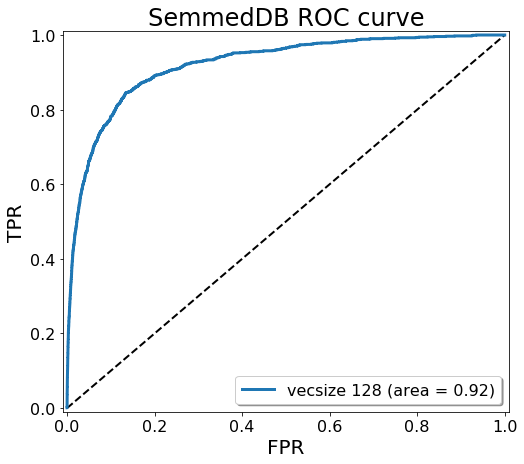

In [19]:
plot_roc(
    results,
    ["predval"],
    {"predval": "vecsize 128"},
    title="SemmedDB ROC curve"
)

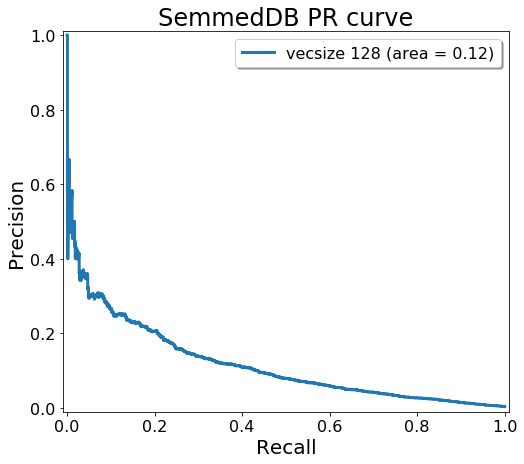

In [20]:
plot_pr(
    results,
    ["predval"],
    {"predval": "vecsize 128"},
    title="SemmedDB PR curve"
)

In [21]:
results.head()

,chemical_id,disease_id,predval,category
0,C0000473,C0001144,0.280261,0
1,C0000545,C0001144,0.460353,0
2,C0000618,C0001144,0.158595,0
3,C0000956,C0001144,0.013283,0
4,C0000970,C0001144,0.065635,0


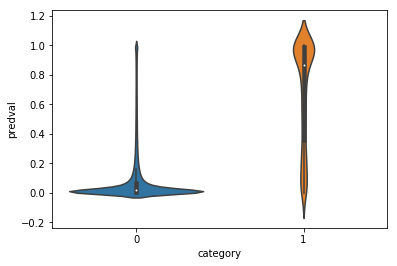

In [22]:
sns.violinplot(data=results, x="category", y="predval")

In [23]:
results["category"].value_counts()

0    319529
1      1230
Name: category, dtype: int64

In [25]:
nodemap = pd.read_csv("data/node_map.tsv", sep='\t')

In [32]:
lel = (results
    .merge(
        nodemap[["node_id", "name"]], how="inner",
        left_on="chemical_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"name": "chemical_name"})
    .merge(
        nodemap[["node_id", "name"]], how="inner",
        left_on="disease_id", right_on="node_id"
    )
    .drop("node_id", axis=1)
    .rename(columns={"name": "disease_name"})
    .sort_values('predval', ascending=False)
    .reset_index(drop=True)
)

In [33]:
lel.head()

,chemical_id,disease_id,predval,category,chemical_name,disease_name
0,C0010192,C0010192,1.000000,1,Cosyntropin,Cosyntropin
1,C0049065,C1458155,0.999995,0,5-aza-2'-deoxycytidine,breast cancer
2,C0770560,C0036830,0.999988,1,Hydrocortisone sodium succinate,Serum sickness (disorder)
3,C0040867,C0406326,0.999987,0,triamcinolone diacetate,Scalp psoriasis
4,C0049065,C0153493,0.999985,0,5-aza-2'-deoxycytidine,lung cancer


## Look through results

In [45]:
lel.shape

(320759, 6)

In [50]:
lel.query("category == 0").shape

(319529, 6)

In [49]:
lel.query("category == 0 and predval > 0.5").shape

(19210, 6)

In [52]:
19210/319529

0.06011973874045861

In [51]:
lel.query("predval > 0.5").shape

(20069, 6)

In [44]:
(lel
    .query("category == 0 and predval > 0.95")
    .assign(
        cancer = lambda df: df["disease_name"].str.contains("cancer")
    )
    .query("~cancer")
    .drop("cancer", axis=1)
    .sample(20)
)

,chemical_id,disease_id,predval,category,chemical_name,disease_name
1367,C0023726,C0684256,0.994527,0,Lincomycin,Bacterial septicemia
3677,C0360534,C0014742,0.965476,0,Alclometasone,Erythema Multiforme
2365,C0012963,C0264694,0.984968,0,Dobutamine,coronary artery disease
3631,C0040341,C0154640,0.966404,0,Tobramycin,Staphylococcal meningitis
3072,C0025815,C0343065,0.976028,0,Methylprednisolone,Symptomatic dermographism
4214,C0009011,C0234974,0.954694,0,Clonazepam,Simple Partial Seizures
4192,C0016360,C0026986,0.954999,0,Fluorouracil,Dysmyelopoietic Syndromes
570,C0770560,C0041321,0.998534,0,Hydrocortisone sodium succinate,"Tuberculosis, Miliary"
3981,C0213771,C0006277,0.959474,0,tiotropium,Bronchitis
2439,C0030830,C0030636,0.984032,0,"Penicillin G, Procaine",Pasteurella Infections
